# Suter 2020

In [1]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('qDNA-default')

In [2]:
# -------------
# C13 positions
# -------------
# C13_pos = (8.713976612205478e-10, 0.0, 1.901805289026213e-10) # Suter
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
# C13_pos = (8.73e-10, 0.0, 1.86e-10) # rounded coordinates yield the same fidelities
# C13_pos = (4.722331100730915e-10, 0.0, 1.030637866442101e-10) # Dennis 

# -----------------------
# target gates and states
# -----------------------

init_state = q.tensor( q.fock_dm(2,0), q.fock_dm(2,0) )

# CNOT
cnot_gate = get_cnot_gate(2, 0, 1)
cnot_state = cnot_gate * init_state * cnot_gate.dag()

# Hadamard
hada_gate = get_hada_gate(2, 1)
hada_state = hada_gate * init_state * hada_gate.dag()

# Bell (Hadamard and CNOT)
bell_gate = get_cnot_gate(2, 0, 1) * get_hada_gate(2, 0)
bell_state = bell_gate * init_state * bell_gate.dag()

# ---------------
# Pulse Sequences
# ---------------

# Suter Hadamard gate
# pulse_seq = [0.74e-6, 0.22e-6, 0.43e-6, 0.89e-6, 0.23e-6, 1.26e-6, 1.50e-6, 3*np.pi/2, 3*np.pi/2, np.pi/2]

# Suter CNOT gate
# pulse_seq = [3.78e-6, 2.11e-6, 2.15e-6, 0.63e-6, 1.88e-6, 3.96e-6, 1.9e-6, 0, np.pi/5, np.pi/2] 

# Dominik Bell state (without DD)
# pulse_seq = [0, 4.06620465e-6, 1.57022726e-6, 1.50788214e-6, 0.99813568, 3.57557112, 1.68300382, 0.69459264, 1.97327426, 0.50816523]

# Dominik Bell state (with DD)
# pulse_seq = [0, 3.93e-6, 2.95e-6, 2.28e-6, 0.30e-6, -1.06, 4.68, 2.07, 0, -0.53, 6.26, -1.76, 0]

In [3]:
# parameters
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]
bath_configs = list( load_spin_baths('Dominik_C13', DATA_DIR).values() )[:10]

kwargs = dict(suter_method=True, instant_pulses=True, verbose=False,
             old_state=bell_state, target=bell_state, env_approx_level='no_bath')

## Hamiltonian

In [4]:
kwargs['Suter_method'] = False

register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]
bath_config = SpinBath('C13', 0.02e-2, 2e-9, 4.2e-9).config
approx_level = 'no_bath'

hamiltonian = Hamiltonian(register_config, bath_config, approx_level)
my_ham = hamiltonian.matrices[0]
suter_ham =  H_Suter()

print( 'Dennis: ', my_ham )
print( 'Suter: ', suter_ham )

Dennis:  Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-7.92540000e+04  0.00000000e+00  6.03893430e+03  2.84030169e+04]
 [ 0.00000000e+00  7.92540000e+04  8.61168980e+03 -6.03893430e+03]
 [ 6.03893430e+03  8.61168980e+03  2.46332892e+09 -8.54034278e+03]
 [ 2.84030169e+04 -6.03893430e+03 -8.54034278e+03  2.46346308e+09]]
Suter:  Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-79000.      0.      0.      0.]
 [     0.  79000.      0.      0.]
 [     0.      0.  -3000. -55000.]
 [     0.      0. -55000.   3000.]]


## Instant Hadamard (Appendix)

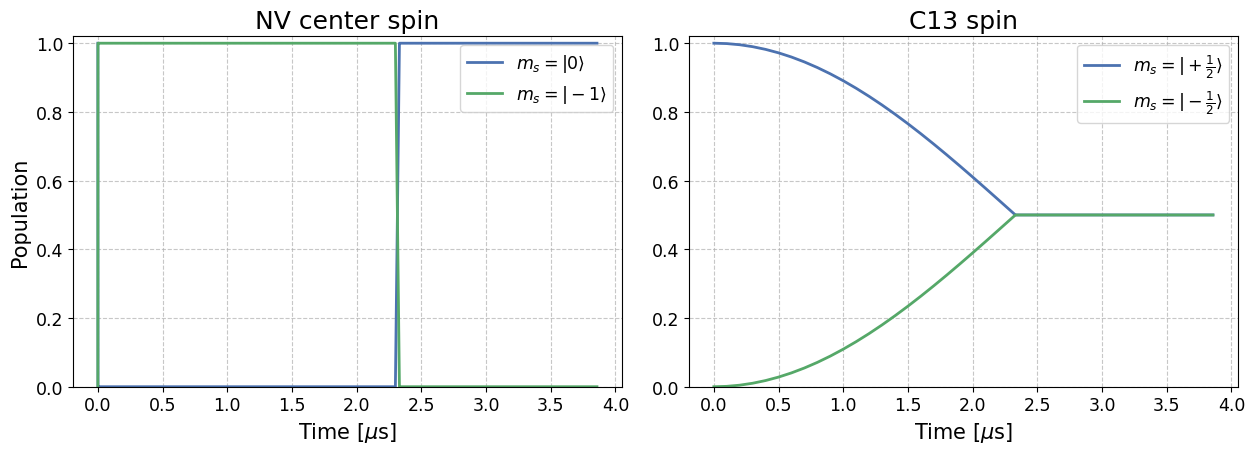

In [5]:
# Analytical times 
T1, T2 = calc_hadamard_pulse_seq(C13_pos, suter_method=True)

# C13 superposition 
NV_state = q.basis(2,0)
C13_state = 1/np.sqrt(2) * ( q.basis(2,0) + q.basis(2,1) )
target = q.tensor(NV_state*NV_state.dag(), C13_state*C13_state.dag())

kwargs['Suter_method'] = True
kwargs['target'] = target
env = Environment(register_config, bath_configs, **kwargs)
env.old_state = None
env.pulse_seq = [0, T1, T2, np.pi, np.pi, 0, 0]

t_list = env.get_t_list(stepsize=0.1e-6)
    
new_states_full = env.calc_new_states_full(t_list)
new_states = new_states_full[0]
fig, ax = plot_pops(t_list, new_states)

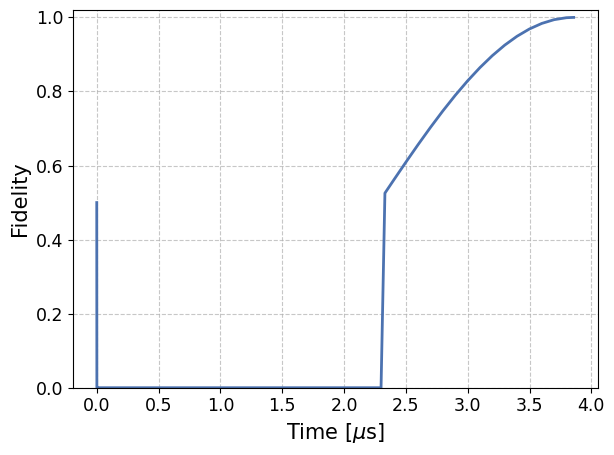

In [6]:
fidelities = env.calc_fidelities_full(new_states_full)[0]
fig, ax = plot_fids(t_list, fidelities)

## Hadamard

## CNOT